# IT3212 - Assignment 2

## Setup

In [107]:
import pandas as pd

filepath = '../data/disaster-tweets.csv'
df = pd.read_csv(filepath, encoding='ISO-8859-1')

## 1. Implement the preprocessing

### 1.1 Removing data

In [108]:
# Only keep the columns we need
original_features = [
  '_unit_id', '_golden', '_unit_state', '_trusted_judgments',
  '_last_judgment_at', 'choose_one', 'choose_one:confidence',
  'choose_one_gold', 'keyword', 'location', 'text', 'tweetid', 'userid'
  ]
features_to_keep = ['choose_one', 'choose_one:confidence', 'keyword', 'location', 'text']
df = df[features_to_keep]
print(df.columns)

# Remove rows with a confidence score less than 1.0
confidence_threshold = 1.0
df = df[df['choose_one:confidence'] >= confidence_threshold]

# Write the updated dataframe to a new CSV file
df.to_csv('./results/01-remove-features.csv', index=False)

Index(['choose_one', 'choose_one:confidence', 'keyword', 'location', 'text'], dtype='object')


### 1.2 Text processing

In [109]:
from urllib.parse import unquote

# Clean `keyword` column.
def clean_keyword(keyword: str):
    return unquote(keyword) if pd.notnull(keyword) else ''

df['keyword'] = df['keyword'].apply(clean_keyword)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/02-clean-keywords.csv', index=False)


In [110]:
# Remove links from the `text` column
import string
import re


def clean_text(text: str):
  text = re.sub(r'https?://\S+', '', text)  # Remove link
  text = re.sub(r'\n', ' ', text)  # Remove line breaks
  # Remove leading, trailing, and extra spaces
  text = re.sub('\s+', ' ', text).strip()
  return text


df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

# Remove punctuation from the `text` column
df['cleaned_text'] = df['text'].apply(lambda x: x.translate(
    str.maketrans('', '', string.punctuation)))

# Write the updated dataframe to a new CSV file
df.to_csv('./results/03-clean-text.csv', index=False)


In [111]:
# Remove English stopwords
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Clean `text` column.
def clean_text(text: str):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


df['cleaned_text'] = df['text'].apply(clean_text)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/04-without-stopwords.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/magnusrodseth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
# Lemmatizing the `text` column
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Clean `text` column.
def clean_text(text: str):
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text


df['cleaned_text'] = df['text'].apply(clean_text)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/05-lemmatized.csv', index=False)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/magnusrodseth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [113]:
# Remove special characters
def clean_text(text: str):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/06-without-special-chars.csv', index=False)

### 1.3 Handling categorical data

In [114]:
# Remove rows with `choose_one` value of `Can't Decide`
df = df[df['choose_one'] != "Can't Decide"]

# Replace the `choose_one` column with a new column called `target`, where `Relevant` is `1` and `Not Relevant` is `0`
df['target'] = df['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/07-with-target-variable.csv', index=False)

### 1.4 Duplicated data

In [115]:
# Remove duplicated rows with respect to the `text` column
df = df.drop_duplicates(subset=['text'])

print(df.head())

# Write the updated dataframe to a new CSV file
df.to_csv('./results/08-without-duplicates-in-text.csv', index=False)

  choose_one  choose_one:confidence keyword location  \
0   Relevant                    1.0              NaN   
1   Relevant                    1.0              NaN   
2   Relevant                    1.0              NaN   
4   Relevant                    1.0              NaN   
5   Relevant                    1.0              NaN   

                                                text  \
0                 Just happened a terrible car crash   
1  Our Deeds are the Reason of this #earthquake M...   
2  Heard about #earthquake is different cities, s...   
4             Forest fire near La Ronge Sask. Canada   
5  All residents asked to 'shelter in place' are ...   

                                        cleaned_text  target  
0                 Just happened a terrible car crash       1  
1  Our Deeds are the Reason of this earthquake Ma...       1  
2  Heard about earthquake is different cities sta...       1  
4              Forest fire near La Ronge Sask Canada       1  
5  All resi

## 2. Extracting features

> TODO: Extract features from the preprocessed data

## 3. Selecting features

> TODO: Select features from the extracted features

## 4. Implement basic modelling methods

In [116]:
from sklearn.model_selection import train_test_split

# Using TF-IDF Vectorizer for 'cleaned_text' column
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['cleaned_text'])

# Assuming y is your target variable & X_text is your feature
y = df['target']

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)


### 4.1 Logistic regression

Accuracy: 0.9082998661311914
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       847
           1       0.93      0.86      0.89       647

    accuracy                           0.91      1494
   macro avg       0.91      0.90      0.91      1494
weighted avg       0.91      0.91      0.91      1494

Confusion Matrix: 
 [[803  44]
 [ 93 554]]


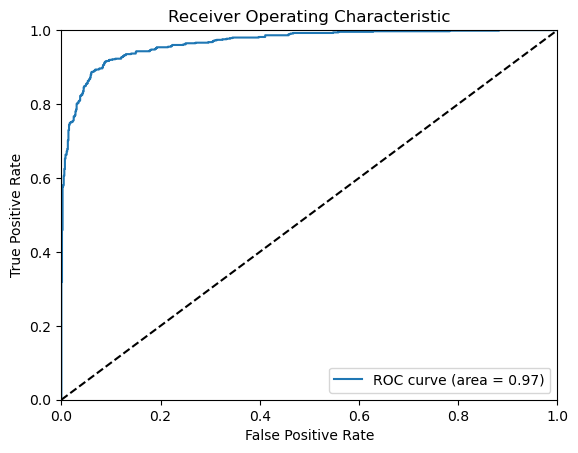

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize Logistic Regression Model
logreg = LogisticRegression(random_state=42)

# Fit the model
logreg.fit(x_train, y_train)

# Predictions
y_pred = logreg.predict(x_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification Report
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

# Confusion Matrix
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
